# Setting up a structure

***Prerequisites***: we suppose that you have successfully installed and configured AiiDA. For some help, please have a look at the [AiiDA tutorials](https://aiida-tutorials.readthedocs.io/en/latest/).

It is possible, using [ASE](https://wiki.fysik.dtu.dk/ase/) (and also [Pymatgen](https://pymatgen.org/) in a similar way), to read a QE in/out file and load a given crystal structure. 
To create a structures from scratch, see the dedicated [ASE tutorial](https://wiki.fysik.dtu.dk/ase/gettingstarted/tut01_molecule/molecule.html).

We start loading the necessary module from ASE package:

In [1]:
from ase.io.espresso import read_espresso_in

The next step is to use the `read_espresso_in` method to load the structure from a `pw.x` input file: 

In [2]:
Silicon = read_espresso_in('../data/silicon.in')

Now inspect the created `Atoms` object: 

In [3]:
Silicon

Atoms(symbols='Si2', pbc=True, cell=[[-2.6988037626030605, 0.0, 2.6988037626030605], [0.0, 2.6988037626030605, 2.6988037626030605], [-2.6988037626030605, 2.6988037626030605, 0.0]], initial_magmoms=...)

The `hBN` variable contains all the informations needed to store the structure in the AiiDA database. 
So, we start by loading our AiiDA profile and modules as follows:

In [4]:
from aiida import orm, load_profile
load_profile()

Profile<uuid='b35700dae723411ea16ebc82d58f16bc' name='mb'>

We are now ready to create the `StructureData` instance of our structure, and to store it in the AiiDA database:

In [6]:
structure = orm.StructureData(ase=Silicon)
structure.store()

<StructureData: uuid: 6bf5c788-3850-48a4-8b40-2acfb29ccf25 (pk: 16907)>

The structure *id*, as stored in the database, can be accessed via the `pk` attribute:

In [7]:
structure.pk

16907

<Axes: >

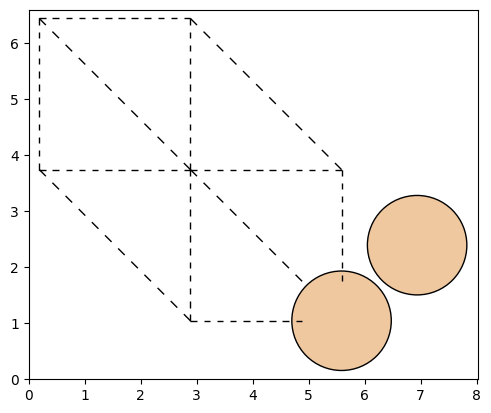

In [9]:
from ase.visualize.plot import plot_atoms

plot_atoms(Silicon, radii=0.8, rotation=('0x,0y,0z'))

# Store pseudopotentials

To run AiiDA simulations for DFT and MBPT, we need to store the desired pseudopotential family in the database.

The command is:

    aiida-pseudo install family <ARCHIVE> <LABEL> -P pseudo.upf

more details are provided [here](https://aiida-pseudo.readthedocs.io/en/latest/howto.html)

When you use protocols, you have to provide families which have one. SSSP or PseudoDojo. 
If you want to use another family, for example sg15, you generate the builder protocols with SSSP or PseudoDojo, then:

```python
    family = orm.load_group("sg15")
    builder.<sublevels_up_to .pw>.pseudos = family.get_pseudos(structure=structure) 
```

# Group creation and usage

Groups are a powerful tool in AiiDA, they allow to group calculations and to easy query them. To see examples of query and creation/management of groups, see [here](https://aiida.readthedocs.io/projects/aiida-core/en/latest/howto/data.html?highlight=groups).

In [11]:
new_group = orm.Group('Silicon/bulk')

In [12]:
try:
    new_group.store()
except:
    print("The group '{}' already exists!".format(new_group.label))

You can add nodes to the group, both from here or from the command line. Here you can load a node and add to the group

```python   
    node = orm.load_node(pk or uuid)
    new_group.add_nodes(node)
```

In [13]:
node = orm.load_node(16907) # structure.pk
new_group.add_nodes(node)

## How to query the StructureData to reuse it

For more details please have a look at [here](https://aiida.readthedocs.io/projects/aiida-core/en/latest/howto/query.html)

In [14]:
from aiida.orm import QueryBuilder

In [15]:
# Querying the structures that belong to the 'promising_structures' group.
qb = QueryBuilder()
qb.append(orm.Group, filters={'label': 'Silicon/bulk'}, tag='group')
qb.append(orm.StructureData, with_group='group')

QueryBuilder(path=[{'entity_type': 'group.core', 'orm_base': 'group', 'tag': 'group', 'joining_keyword': None, 'joining_value': None, 'edge_tag': None, 'outerjoin': False}, {'entity_type': 'data.core.structure.StructureData.', 'orm_base': 'node', 'tag': 'StructureData_1', 'joining_keyword': 'with_group', 'joining_value': 'group', 'edge_tag': 'group--StructureData_1', 'outerjoin': False}], filters={'group': {'type_string': {'like': '%'}, 'label': 'Silicon/bulk'}, 'StructureData_1': {'node_type': {'like': 'data.core.structure.%'}}, 'group--StructureData_1': {}}, project={'group': [], 'StructureData_1': [], 'group--StructureData_1': []}, order_by=[], limit=None, offset=None, distinct=False)

In [16]:
# Print the query results.
for structure in qb.all(flat=True):
    print(structure)

uuid: 6bf5c788-3850-48a4-8b40-2acfb29ccf25 (pk: 16907)


In [17]:
our_structure = qb.all()[0][0]